In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
y = np.log(train['SalePrice'])
train.drop('SalePrice', axis=1, inplace=True)
test_id = test['Id']
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)


train_empty = train.loc[:, train.isnull().sum() > 0]
# grab the columns
cols = train_empty.columns.tolist()
# fill with the appropriate value  -- NA, Other, could also work
train[['GarageType', 'GarageFinish']] = train[['GarageType', 'GarageFinish']].fillna('None')
test[['GarageType', 'GarageFinish']]  = test[['GarageType', 'GarageFinish']].fillna('None')

# we'll use this for GarageYrBlt since it's a numeric column
train['GarageYrBlt'].fillna(0, inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)

# finding the values to use in the training set
ms_mode   = train['MSZoning'].mode()[0]
gcarsmean = train['GarageCars'].mean()

# and applying them to the test set
test['MSZoning'].fillna(ms_mode, inplace=True)
test['GarageCars'].fillna(gcarsmean, inplace=True)

In [4]:
train['MSSubClass'] = train['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

garage_mapping = {
    'None': 1,
    'Unf': 2,
    'RFn': 3,
    'Fin': 4
}

col_mapping = {
    'col': 'GarageFinish',
    'mapping': garage_mapping
}

In [5]:
from category_encoders import OrdinalEncoder, OneHotEncoder

In [6]:
from sklearn.pipeline import Pipeline

In [7]:
oh = OneHotEncoder()
ore = OrdinalEncoder(cols=['GarageFinish'], mapping=[col_mapping])

In [8]:
import xgboost as xgb
boost = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', eval_metric='rmse', seed=100)

In [ ]:
xgb.XGBClassifier()

In [10]:
encoder_pipe = Pipeline([('ore', ore), ('oh', oh)])
btrain = encoder_pipe.fit_transform(train)
btest = encoder_pipe.transform(test)
pipe = Pipeline([('ore', ore), ('oh', oh), ('xgbr', boost)])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(btrain, y, test_size=0.3)

In [12]:
# xgtrain = xgb.DMatrix(train.values, label=y.values)
?xgb.cv

Signature:
xgb.cv(
    params,
    dtrain,
    num_boost_round=10,
    nfold=3,
    stratified=False,
    folds=None,
    metrics=(),
    obj=None,
    feval=None,
    maximize=False,
    early_stopping_rounds=None,
    fpreproc=None,
    as_pandas=True,
    verbose_eval=None,
    show_stdv=True,
    seed=0,
    callbacks=None,
    shuffle=True,
)
Docstring:
Cross-validation with given parameters.

Parameters
----------
params : dict
    Booster params.
dtrain : DMatrix
    Data to be trained.
num_boost_round : int
    Number of boosting iterations.
nfold : int
    Number of folds in CV.
stratified : bool
    Perform stratified sampling.
folds : a KFold or StratifiedKFold instance or list of fold indices
    Sklearn KFolds or StratifiedKFolds object.
    Alternatively may explicitly pass sample indices for each fold.
    For ``n`` folds, **folds** should be a length ``n`` list of tuples.
    Each tuple is ``(in,out)`` where ``in`` is a list of indices to be used
    as the training sam

In [13]:
y.name

'SalePrice'

In [21]:
import boosting_utils as utils
from importlib import reload
reload(utils)

<module 'boosting_utils' from 'C:\\Users\\afs95\\MyPython\\DataScienceGA\\DS_work\\DS_repo\\Lectures\\Unit3\\boosting_utils.py'>

Training RMSE: 0.1045
Test RMSE: 0.1306


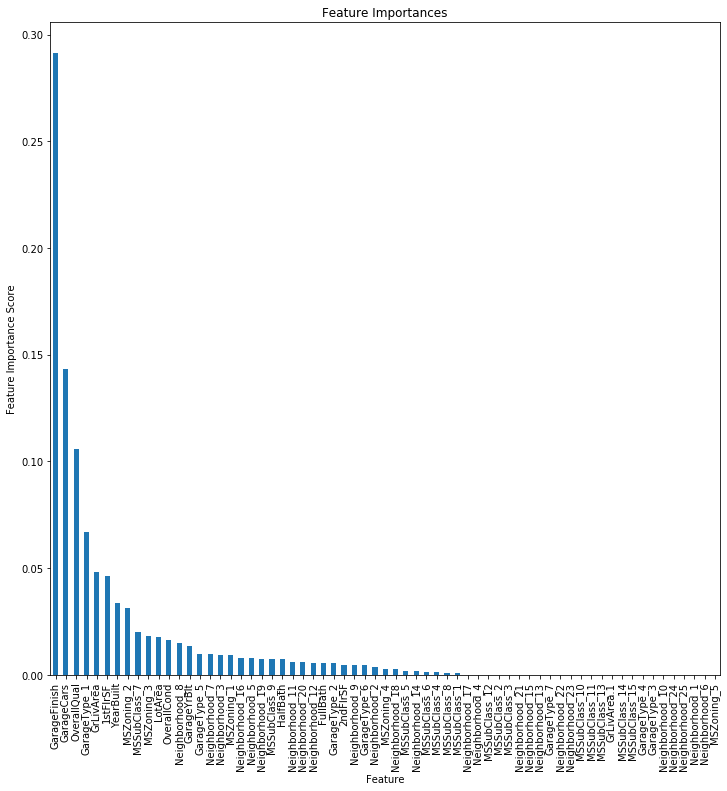

In [22]:
utils.fit_model(boost, X_train, y_train, X_val, y_val)

In [23]:
boost

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=100, silent=None,
             subsample=1, verbosity=1)

In [24]:
xgb1 = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', eval_metric='rmse', n_estimators=1000,
                        nthread=4, seed=100)
xgb1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=1000, n_jobs=1, nthread=4,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=100, silent=None,
             subsample=1, verbosity=1)

Training RMSE: 0.08334
Test RMSE: 0.1288


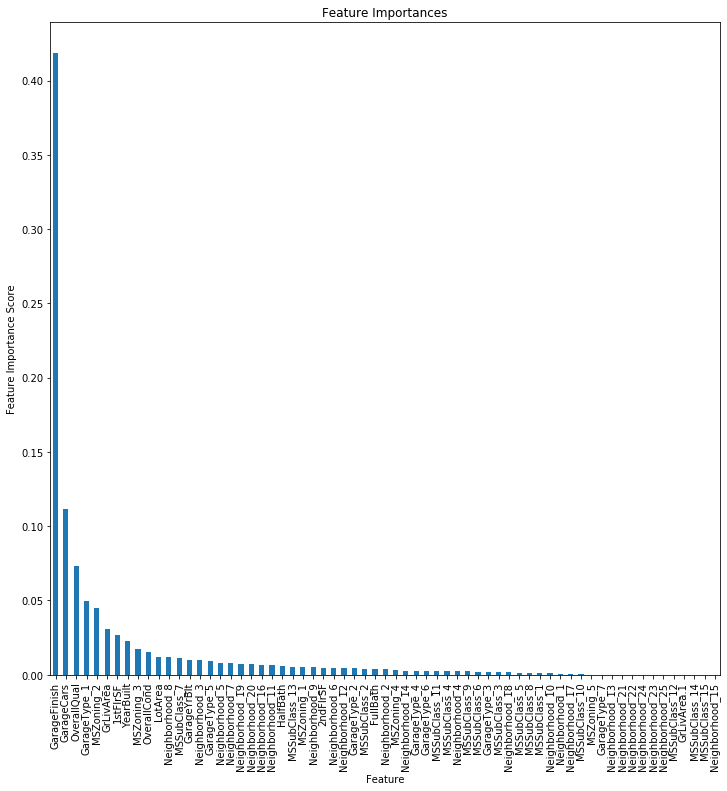

In [25]:
utils.fit_model(xgb1, X_train, y_train, X_val, y_val)

In [26]:
xgb1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=213, n_jobs=1, nthread=4,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=100, silent=None,
             subsample=1, verbosity=1)

In [27]:
xgb1preds = xgb1.predict(btest.values)

In [28]:
xgb1_sub = pd.DataFrame({
    'Id': range(1461, 2920),
    'SalePrice': np.exp(xgb1preds)
})

xgb1_sub

,Id,SalePrice
0,1461,124026.257812
1,1462,152585.031250
2,1463,173639.125000
3,1464,180185.609375
4,1465,197734.828125
...,...,...
1454,2915,79944.523438
1455,2916,78246.406250
1456,2917,150712.171875
1457,2918,118194.976562


In [107]:
xgb1_sub.to_csv('data/xgb1.csv', index=False)

In [34]:
# 213 estimators was the stopping point at the last go aroun
n_est = 213
xgb2 = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', eval_metric='rmse', n_estimators=n_est,
                        nthread=4, max_depth=5, subsample=0.8, seed=100)

Training RMSE: 0.05227
Test RMSE: 0.128


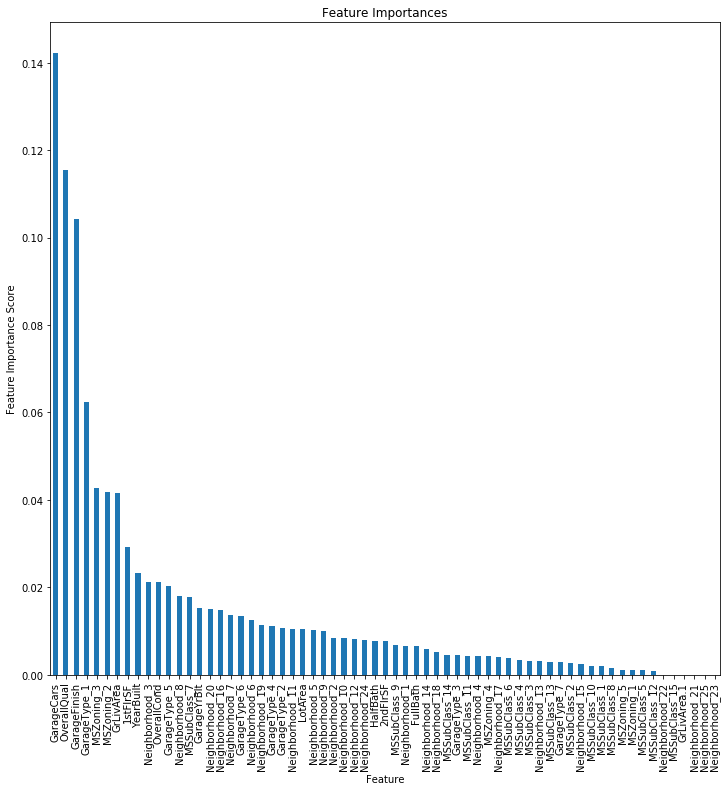

In [35]:
utils.fit_model(xgb2, X_train, y_train, X_val, y_val)

In [36]:
xgb2preds = xgb2.predict(btest.values)

xgb2_sub = pd.DataFrame({
    'Id': range(1461, 2920),
    'SalePrice': np.exp(xgb2preds)
})
xgb2_sub.to_csv('data/xgb2.csv', index=False)

xgb2_sub

,Id,SalePrice
0,1461,125708.281250
1,1462,157847.734375
2,1463,170828.625000
3,1464,183027.125000
4,1465,194229.734375
...,...,...
1454,2915,79045.101562
1455,2916,76527.773438
1456,2917,162254.062500
1457,2918,128106.750000


In [32]:
xgb2

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
             n_estimators=110, n_jobs=1, nthread=4,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8, verbosity=1)

In [33]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', eval_metric='rmse', n_estimators=n_est,
#                         nthread=4, max_depth=5, subsample=0.8)

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator- xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', eval_metric='rmse', n_estimators=n_est,
                        nthread=4, max_depth=5, subsample=0.8, colsample_bytree=0.8, seed=100), param_grid = param_test1, 
                        scoring='rmse', n_jobs=4, cv=5)